In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from scipy import stats
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from pandas import Series
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

In [2]:
df = pd.read_csv('*/LimFiles.csv', header=0, index_col=0)

In [3]:
df

,Loperamide,Windspeed,AirTemp,Evaporation,Humidity,Pressure,Precipitation,Tmax,Tmin
DateTime,,,,,,,,,
2008/11/17,7,2.578032,297.750,506.75,0.012425,90060.0,9.990000e-08,301.025,294.125
2008/11/18,8,3.889891,297.925,712.50,0.011975,90230.0,9.990000e-08,301.125,294.125
2008/11/19,12,4.062404,294.100,445.50,0.013200,90735.0,3.930000e-05,296.500,291.650
2008/11/20,13,2.393872,294.150,291.25,0.013050,90862.5,2.510000e-05,295.650,292.100
2008/11/21,15,2.864655,294.925,341.00,0.013425,90747.5,1.080000e-05,296.775,292.950
...,...,...,...,...,...,...,...,...,...
2019/02/28,18,1.546165,296.975,416.75,0.014050,90315.0,0.000000e+00,301.300,292.975
2019/03/01,54,2.238861,297.050,459.00,0.015150,90415.0,3.000000e-06,300.225,293.250
2019/03/02,58,2.343075,297.100,403.50,0.016275,90432.5,6.250000e-06,299.725,293.875


In [4]:
values = df.values
# ensure all data is float
values = values.astype('float32')

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# frame as supervised learning
#past,future
reframed = series_to_supervised(values,5, 1)
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var1(t-4),...,var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
5,7.0,2.578032,297.750000,506.75,0.012425,90060.0,9.990000e-08,301.024994,294.125000,8.0,...,292.950012,15.0,0.797653,293.250000,194.25,0.013925,90375.0,0.000058,295.625000,291.299988
6,8.0,3.889891,297.924988,712.50,0.011975,90230.0,9.990000e-08,301.125000,294.125000,12.0,...,291.299988,15.0,0.903120,293.225006,141.00,0.016250,90312.5,0.000144,297.524994,291.500000
7,12.0,4.062404,294.100006,445.50,0.013200,90735.0,3.930000e-05,296.500000,291.649994,13.0,...,291.500000,20.0,1.594522,294.000000,116.75,0.017025,90420.0,0.000126,296.049988,292.049988
8,13.0,2.393872,294.149994,291.25,0.013050,90862.5,2.510000e-05,295.649994,292.100006,15.0,...,292.049988,12.0,2.151308,295.024994,154.75,0.017700,90605.0,0.000110,296.825012,293.100006
9,15.0,2.864655,294.924988,341.00,0.013425,90747.5,1.080000e-05,296.774994,292.950012,15.0,...,293.100006,13.0,2.285416,294.450012,181.50,0.017025,90670.0,0.000096,296.924988,292.950012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3755,54.0,1.725181,296.600006,393.00,0.013150,90367.5,0.000000e+00,300.125000,292.700012,42.0,...,293.649994,18.0,1.546165,296.975006,416.75,0.014050,90315.0,0.000000,301.299988,292.975006
3756,42.0,1.142640,299.575012,358.25,0.013675,90250.0,0.000000e+00,304.850006,293.825012,42.0,...,292.975006,54.0,2.238861,297.049988,459.00,0.015150,90415.0,0.000003,300.225006,293.250000
3757,42.0,3.074594,298.600006,539.00,0.015575,90465.0,0.000000e+00,301.174988,295.450012,33.0,...,293.250000,58.0,2.343075,297.100006,403.50,0.016275,90432.5,0.000006,299.725006,293.875000
3758,33.0,1.583114,295.100006,205.50,0.015975,90262.5,7.400000e-05,297.975006,293.200012,45.0,...,293.875000,23.0,2.458785,298.200012,453.50,0.015800,90412.5,0.000002,301.274994,294.774994


In [7]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[46,47,48,49,50,51,52,53]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[55,56,57,58,59,60,61,62]], axis=1, inplace=True)
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var1(t-4),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
5,7.0,2.578032,297.750000,506.75,0.012425,90060.0,9.990000e-08,301.024994,294.125000,8.0,...,15.0,2.864655,294.924988,341.00,0.013425,90747.5,0.000011,296.774994,292.950012,15.0
6,8.0,3.889891,297.924988,712.50,0.011975,90230.0,9.990000e-08,301.125000,294.125000,12.0,...,15.0,0.797653,293.250000,194.25,0.013925,90375.0,0.000058,295.625000,291.299988,15.0
7,12.0,4.062404,294.100006,445.50,0.013200,90735.0,3.930000e-05,296.500000,291.649994,13.0,...,15.0,0.903120,293.225006,141.00,0.016250,90312.5,0.000144,297.524994,291.500000,20.0
8,13.0,2.393872,294.149994,291.25,0.013050,90862.5,2.510000e-05,295.649994,292.100006,15.0,...,20.0,1.594522,294.000000,116.75,0.017025,90420.0,0.000126,296.049988,292.049988,12.0
9,15.0,2.864655,294.924988,341.00,0.013425,90747.5,1.080000e-05,296.774994,292.950012,15.0,...,12.0,2.151308,295.024994,154.75,0.017700,90605.0,0.000110,296.825012,293.100006,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3755,54.0,1.725181,296.600006,393.00,0.013150,90367.5,0.000000e+00,300.125000,292.700012,42.0,...,45.0,1.175266,297.899994,335.50,0.015100,90230.0,0.000003,301.399994,293.649994,18.0
3756,42.0,1.142640,299.575012,358.25,0.013675,90250.0,0.000000e+00,304.850006,293.825012,42.0,...,18.0,1.546165,296.975006,416.75,0.014050,90315.0,0.000000,301.299988,292.975006,54.0
3757,42.0,3.074594,298.600006,539.00,0.015575,90465.0,0.000000e+00,301.174988,295.450012,33.0,...,54.0,2.238861,297.049988,459.00,0.015150,90415.0,0.000003,300.225006,293.250000,58.0
3758,33.0,1.583114,295.100006,205.50,0.015975,90262.5,7.400000e-05,297.975006,293.200012,45.0,...,58.0,2.343075,297.100006,403.50,0.016275,90432.5,0.000006,299.725006,293.875000,23.0


In [8]:
# extract out the features and labels into separate variables
y = reframed['var1(t)'].values
reframed = reframed.drop('var1(t)', axis=1)

In [9]:
X = reframed.values
feature_names = reframed.columns
print('dimension: ', X.shape)
reframed.head()

dimension:  (3755, 45)


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var1(t-4),...,var9(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1)
5,7.0,2.578032,297.750000,506.75,0.012425,90060.0,9.990000e-08,301.024994,294.125000,8.0,...,292.100006,15.0,2.864655,294.924988,341.00,0.013425,90747.5,0.000011,296.774994,292.950012
6,8.0,3.889891,297.924988,712.50,0.011975,90230.0,9.990000e-08,301.125000,294.125000,12.0,...,292.950012,15.0,0.797653,293.250000,194.25,0.013925,90375.0,0.000058,295.625000,291.299988
7,12.0,4.062404,294.100006,445.50,0.013200,90735.0,3.930000e-05,296.500000,291.649994,13.0,...,291.299988,15.0,0.903120,293.225006,141.00,0.016250,90312.5,0.000144,297.524994,291.500000
8,13.0,2.393872,294.149994,291.25,0.013050,90862.5,2.510000e-05,295.649994,292.100006,15.0,...,291.500000,20.0,1.594522,294.000000,116.75,0.017025,90420.0,0.000126,296.049988,292.049988
9,15.0,2.864655,294.924988,341.00,0.013425,90747.5,1.080000e-05,296.774994,292.950012,15.0,...,292.049988,12.0,2.151308,295.024994,154.75,0.017700,90605.0,0.000110,296.825012,293.100006


In [10]:
import SVM_Evolution #Revac module
#np.random.seed(2)

In [11]:
numberOfParents = 80 #number of parents to start
numberOfParentsMating = 2 #number of parents that will mate
numberOfParameters = 2 #number of parameters that will be optimized
numberOfGenerations =100  #number of genration that will be created

In [12]:
#initialize population
population=SVM_Evolution.init_poplulation(numberOfParents)

In [13]:
fitnessValue = SVM_Evolution.Calculate_Fitness(population,X, y, test_size=0.3)

In [14]:
#define an array to store the fitness  hitory
fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])

#insert the value of initial parameters of fitness history
fitnessHistory[0, :] = fitnessValue

#define an array to store the value of each parameter for each parent and generation
populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])

#insert the value of initial parameters to history
populationHistory[0:numberOfParents, :] = population

In [15]:
for generation in range(numberOfGenerations):
    
    print("This is number %s generation" % (generation))
    
    print("------------fitness values-------------------")
    print(fitnessValue)
    
    #best score in the current iteration
    print('Best RMSE score in the this iteration = {}'.format(np.min(fitnessHistory[generation, :]))) # we can add a condition to break heare

    #survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    parents = SVM_Evolution.new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
    print('----------------Best parents---------------------')
    print(parents)
    
    #mate these parents to create children having parameters from these parents (we are using uniform crossover)
    children = SVM_Evolution.crossover_uniform(parents=parents, numberOfParameters=2, NumChild=1)
    
    print('---------crossover------------')
    print(children)
    
    #add mutation to create genetic diversity
    children_mutated = SVM_Evolution.mutation(children)
    #children_mutated=SVM_Evolution.Single_mutation(children, numberOfParameters=2)
    
    '''
    We will create new population, in which n children will replace the worst n parents based on the
    fitness score and rest of them  will be children
    '''
    
    poulation,childIndex =SVM_Evolution.parents_replacement(population=population, fitness=fitnessValue, numParents=1, Children=children_mutated)
    
    #Update fitnessValues
    
    fitnessValue = SVM_Evolution.UpdateFitnessValues(population, childIndex, fitnessValue, X, y, test_size=0.3)
    
    print("---------------updated fitness Value---------------------------")
    print(fitnessValue)
    
    fitnessHistory[(generation+1), :] = fitnessValue
    
    populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population #srore parent information
    

This is number 0 generation
------------fitness values-------------------
[16.149, 16.416, 16.441, 15.874, 16.442, 16.426, 16.268, 16.424, 16.442, 16.417, 16.525, 16.439, 15.169, 16.302, 16.437, 14.56, 16.435, 16.442, 16.308, 14.219, 16.443, 16.411, 13.035, 15.826, 16.376, 16.434, 16.378, 12.615, 16.434, 15.311, 15.619, 16.442, 16.352, 16.025, 16.404, 12.947, 15.208, 15.056, 13.941, 13.142, 16.435, 15.32, 12.884, 16.441, 16.441, 16.422, 12.841, 16.421, 16.407, 16.427, 16.399, 16.429, 16.423, 15.869, 16.441, 16.443, 13.131, 16.426, 16.416, 16.437, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 16.437, 15.578, 16.44, 16.382, 16.421, 16.436, 16.416, 16.366, 16.435, 13.771, 16.876, 14.041, 13.285, 16.327]
Best RMSE score in the this iteration = 12.615
----------------Best parents---------------------
[[3.193e+01 3.000e-02]
 [6.941e+00 7.400e-02]]
---------crossover------------
[[6.941 0.03 ]]
The worst parent index for this iteration is :
[76]
this is the child rmse 12.211
---------------

this is the child rmse 10.627
---------------updated fitness Value---------------------------
[16.149, 16.416, 16.441, 15.874, 16.442, 16.426, 16.268, 16.424, 16.442, 16.417, 12.569, 16.439, 15.169, 16.302, 16.437, 14.56, 16.435, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376, 16.434, 16.378, 12.615, 16.434, 15.311, 15.619, 13.088, 16.352, 16.025, 16.404, 12.947, 15.208, 15.056, 13.941, 13.142, 16.435, 15.32, 12.884, 16.441, 16.441, 16.422, 12.841, 16.421, 16.407, 16.427, 16.399, 16.429, 16.423, 15.869, 16.441, 12.399, 13.131, 16.426, 16.416, 16.437, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 16.437, 15.578, 16.44, 16.382, 16.421, 16.436, 16.416, 16.366, 16.435, 13.771, 12.211, 14.041, 13.285, 16.327]
This is number 6 generation
------------fitness values-------------------
[16.149, 16.416, 16.441, 15.874, 16.442, 16.426, 16.268, 16.424, 16.442, 16.417, 12.569, 16.439, 15.169, 16.302, 16.437, 14.56, 16.435, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16

this is the child rmse 10.446
---------------updated fitness Value---------------------------
[16.149, 16.416, 16.441, 15.874, 12.905, 16.426, 16.268, 16.424, 12.934, 16.417, 12.569, 16.439, 15.169, 16.302, 16.437, 14.56, 16.435, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376, 16.434, 16.378, 12.615, 16.434, 15.311, 15.619, 13.088, 16.352, 16.025, 16.404, 12.947, 15.208, 15.056, 13.941, 13.142, 16.435, 15.32, 12.884, 10.446, 12.946, 16.422, 12.841, 16.421, 16.407, 16.427, 16.399, 16.429, 16.423, 15.869, 12.933, 12.399, 13.131, 16.426, 16.416, 16.437, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 16.437, 15.578, 16.44, 16.382, 16.421, 16.436, 16.416, 16.366, 16.435, 13.771, 12.211, 14.041, 13.285, 16.327]
This is number 11 generation
------------fitness values-------------------
[16.149, 16.416, 16.441, 15.874, 12.905, 16.426, 16.268, 16.424, 12.934, 16.417, 12.569, 16.439, 15.169, 16.302, 16.437, 14.56, 16.435, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 1

this is the child rmse 12.946
---------------updated fitness Value---------------------------
[16.149, 16.416, 11.183, 15.874, 12.905, 16.426, 16.268, 16.424, 12.934, 16.417, 12.569, 11.614, 15.169, 16.302, 16.437, 14.56, 16.435, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376, 16.434, 16.378, 12.615, 16.434, 15.311, 15.619, 13.088, 16.352, 16.025, 16.404, 12.947, 15.208, 15.056, 13.941, 13.142, 16.435, 15.32, 12.884, 10.446, 12.946, 16.422, 12.841, 16.421, 16.407, 16.427, 16.399, 16.429, 16.423, 15.869, 12.933, 12.399, 13.131, 16.426, 16.416, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 15.578, 12.93, 16.382, 16.421, 16.436, 16.416, 16.366, 16.435, 13.771, 12.211, 14.041, 13.285, 16.327]
This is number 16 generation
------------fitness values-------------------
[16.149, 16.416, 11.183, 15.874, 12.905, 16.426, 16.268, 16.424, 12.934, 16.417, 12.569, 11.614, 15.169, 16.302, 16.437, 14.56, 16.435, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 1

this is the child rmse 13.299
---------------updated fitness Value---------------------------
[16.149, 16.416, 11.183, 15.874, 12.905, 16.426, 16.268, 16.424, 12.934, 16.417, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376, 16.434, 16.378, 12.615, 16.434, 15.311, 15.619, 13.088, 16.352, 16.025, 16.404, 12.947, 15.208, 15.056, 13.941, 13.142, 12.953, 15.32, 12.884, 10.446, 12.946, 16.422, 12.841, 16.421, 16.407, 16.427, 16.399, 16.429, 16.423, 15.869, 12.933, 12.399, 13.131, 16.426, 16.416, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 15.578, 12.93, 16.382, 16.421, 12.988, 16.416, 16.366, 12.462, 13.771, 12.211, 14.041, 13.285, 16.327]
This is number 21 generation
------------fitness values-------------------
[16.149, 16.416, 11.183, 15.874, 12.905, 16.426, 16.268, 16.424, 12.934, 16.417, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 1

this is the child rmse 12.457
---------------updated fitness Value---------------------------
[16.149, 16.416, 11.183, 15.874, 12.905, 16.426, 16.268, 16.424, 12.934, 16.417, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376, 12.19, 16.378, 12.615, 13.178, 15.311, 15.619, 13.088, 16.352, 16.025, 16.404, 12.947, 15.208, 15.056, 13.941, 13.142, 12.953, 15.32, 12.884, 10.446, 12.946, 16.422, 12.841, 16.421, 16.407, 13.12, 16.399, 13.021, 16.423, 15.869, 12.933, 12.399, 13.131, 12.457, 16.416, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 15.578, 12.93, 16.382, 16.421, 12.988, 16.416, 16.366, 12.462, 13.771, 12.211, 14.041, 13.285, 16.327]
This is number 26 generation
------------fitness values-------------------
[16.149, 16.416, 11.183, 15.874, 12.905, 16.426, 16.268, 16.424, 12.934, 16.417, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.

this is the child rmse 10.288
---------------updated fitness Value---------------------------
[16.149, 16.416, 11.183, 15.874, 12.905, 12.498, 16.268, 13.03, 12.934, 16.417, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376, 12.19, 16.378, 12.615, 13.178, 15.311, 15.619, 13.088, 16.352, 16.025, 16.404, 12.947, 15.208, 15.056, 13.941, 13.142, 12.953, 15.32, 12.884, 10.446, 12.946, 12.959, 12.841, 16.421, 16.407, 13.12, 16.399, 13.021, 13.19, 15.869, 12.933, 12.399, 13.131, 12.457, 16.416, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 15.578, 12.93, 16.382, 10.288, 12.988, 16.416, 16.366, 12.462, 13.771, 12.211, 14.041, 13.285, 16.327]
This is number 31 generation
------------fitness values-------------------
[16.149, 16.416, 11.183, 15.874, 12.905, 12.498, 16.268, 13.03, 12.934, 16.417, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376

this is the child rmse 13.021
---------------updated fitness Value---------------------------
[16.149, 13.021, 11.183, 15.874, 12.905, 12.498, 16.268, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376, 12.19, 16.378, 12.615, 13.178, 15.311, 15.619, 13.088, 16.352, 16.025, 16.404, 12.947, 15.208, 15.056, 13.941, 13.142, 12.953, 15.32, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 16.407, 13.12, 16.399, 13.021, 13.19, 15.869, 12.933, 12.399, 13.131, 12.457, 13.229, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 15.578, 12.93, 16.382, 10.288, 12.988, 12.172, 16.366, 12.462, 13.771, 12.211, 14.041, 13.285, 16.327]
This is number 36 generation
------------fitness values-------------------
[16.149, 13.021, 11.183, 15.874, 12.905, 12.498, 16.268, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 16.411, 13.035, 15.826, 16.376

this is the child rmse 12.95
---------------updated fitness Value---------------------------
[16.149, 13.021, 11.183, 15.874, 12.905, 12.498, 16.268, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 12.938, 13.035, 15.826, 16.376, 12.19, 16.378, 12.615, 13.178, 15.311, 15.619, 13.088, 16.352, 16.025, 11.979, 12.947, 15.208, 15.056, 13.941, 13.142, 12.953, 15.32, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 13.19, 15.869, 12.933, 12.399, 13.131, 12.457, 13.229, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 15.578, 12.93, 12.95, 10.288, 12.988, 12.172, 16.366, 12.462, 13.771, 12.211, 14.041, 13.285, 16.327]
This is number 41 generation
------------fitness values-------------------
[16.149, 13.021, 11.183, 15.874, 12.905, 12.498, 16.268, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 12.938, 13.035, 15.826, 16.376, 

this is the child rmse 12.312
---------------updated fitness Value---------------------------
[16.149, 13.021, 11.183, 15.874, 12.905, 12.498, 16.268, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 12.938, 13.035, 15.826, 12.952, 12.19, 13.284, 12.615, 13.178, 15.311, 15.619, 13.088, 12.932, 16.025, 11.979, 12.947, 15.208, 15.056, 13.941, 13.142, 12.953, 15.32, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 13.19, 15.869, 12.933, 12.399, 13.131, 12.457, 13.229, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 15.578, 12.93, 12.95, 10.288, 12.988, 12.172, 13.231, 12.462, 13.771, 12.211, 14.041, 13.285, 12.312]
This is number 46 generation
------------fitness values-------------------
[16.149, 13.021, 11.183, 15.874, 12.905, 12.498, 16.268, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 16.302, 12.892, 14.56, 13.299, 10.627, 16.308, 14.219, 12.947, 12.938, 13.035, 15.826, 12.952,

this is the child rmse 13.058
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 15.874, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 12.707, 12.892, 14.56, 13.299, 10.627, 12.994, 14.219, 12.947, 12.938, 13.035, 15.826, 12.952, 12.19, 13.284, 12.615, 13.178, 15.311, 15.619, 13.088, 12.932, 13.058, 11.979, 12.947, 15.208, 15.056, 13.941, 13.142, 12.953, 15.32, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 13.19, 15.869, 12.933, 12.399, 13.131, 12.457, 13.229, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 15.578, 12.93, 12.95, 10.288, 12.988, 12.172, 13.231, 12.462, 13.771, 12.211, 14.041, 13.285, 12.312]
This is number 51 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 15.874, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 12.707, 12.892, 14.56, 13.299, 10.627, 12.994, 14.219, 12.947, 12.938, 13.035, 15.826, 12.952,

this is the child rmse 12.466
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 12.707, 12.892, 14.56, 13.299, 10.627, 12.994, 14.219, 12.947, 12.938, 13.035, 13.711, 12.952, 12.19, 13.284, 12.615, 13.178, 15.311, 13.228, 13.088, 12.932, 13.058, 11.979, 12.947, 15.208, 15.056, 13.941, 13.142, 12.953, 15.32, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 13.19, 12.976, 12.933, 12.399, 13.131, 12.457, 13.229, 12.946, 15.499, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 13.231, 12.462, 13.771, 12.211, 14.041, 13.285, 12.312]
This is number 56 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 15.169, 12.707, 12.892, 14.56, 13.299, 10.627, 12.994, 14.219, 12.947, 12.938, 13.035, 13.711, 12.952,

this is the child rmse 13.166
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 13.166, 12.707, 12.892, 14.56, 13.299, 10.627, 12.994, 14.219, 12.947, 12.938, 13.035, 13.711, 12.952, 12.19, 13.284, 12.615, 13.178, 12.957, 13.228, 13.088, 12.932, 13.058, 11.979, 12.947, 13.037, 15.056, 13.941, 13.142, 12.953, 13.051, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 13.19, 12.976, 12.933, 12.399, 13.131, 12.457, 13.229, 12.946, 12.983, 13.216, 14.969, 12.907, 13.088, 13.585, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 13.231, 12.462, 13.771, 12.211, 14.041, 13.285, 12.312]
This is number 61 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 13.166, 12.707, 12.892, 14.56, 13.299, 10.627, 12.994, 14.219, 12.947, 12.938, 13.035, 13.711, 12.952

this is the child rmse 10.287
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 13.166, 12.707, 12.892, 12.957, 13.299, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 13.711, 12.952, 12.19, 13.284, 12.615, 13.178, 12.957, 13.228, 13.088, 12.932, 13.058, 11.979, 12.947, 13.037, 13.024, 13.941, 13.142, 12.953, 13.051, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 13.19, 12.976, 12.933, 12.399, 13.131, 12.457, 13.229, 12.946, 12.983, 13.216, 12.948, 12.907, 13.088, 13.585, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 13.231, 12.462, 13.771, 12.211, 10.287, 13.285, 12.312]
This is number 66 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 13.166, 12.707, 12.892, 12.957, 13.299, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 13.711, 12.9

this is the child rmse 12.969
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 13.166, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.952, 12.19, 13.284, 12.615, 13.178, 12.957, 13.228, 13.088, 12.932, 13.058, 11.979, 12.947, 13.037, 13.024, 12.883, 13.142, 12.953, 13.051, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 13.19, 12.976, 12.933, 12.399, 13.131, 12.457, 13.229, 12.946, 12.983, 13.216, 12.948, 12.907, 13.088, 11.469, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 13.231, 12.462, 12.949, 12.211, 10.287, 13.285, 12.312]
This is number 71 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 13.166, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.9

this is the child rmse 12.112
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 13.166, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.952, 12.19, 13.006, 12.615, 13.178, 12.957, 12.112, 13.088, 12.932, 13.058, 11.979, 12.947, 13.037, 13.024, 12.883, 13.142, 12.953, 13.051, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 13.19, 12.976, 12.933, 12.399, 13.131, 12.457, 13.109, 12.946, 12.983, 13.216, 12.948, 12.907, 13.088, 11.469, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 12.282, 12.462, 12.949, 12.211, 10.287, 12.931, 12.312]
This is number 76 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 13.166, 13.03, 12.934, 12.781, 12.569, 11.614, 13.166, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.9

this is the child rmse 10.434
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 10.434, 13.03, 12.934, 12.781, 12.569, 11.614, 12.952, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.952, 12.19, 13.006, 12.615, 12.551, 12.957, 12.112, 13.088, 12.932, 13.058, 11.979, 12.947, 13.037, 13.024, 12.883, 13.142, 12.953, 13.051, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.12, 11.951, 13.021, 12.855, 12.976, 12.933, 12.399, 13.131, 12.457, 13.109, 12.946, 12.983, 12.96, 12.948, 12.907, 13.088, 11.469, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 12.282, 12.462, 12.949, 12.211, 10.287, 12.931, 12.312]
This is number 81 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 10.434, 13.03, 12.934, 12.781, 12.569, 11.614, 12.952, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.9

this is the child rmse 12.544
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 10.434, 13.03, 12.934, 12.781, 12.569, 11.614, 12.952, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.952, 12.19, 13.006, 12.615, 12.551, 12.957, 12.112, 13.088, 12.932, 13.058, 11.979, 12.947, 13.037, 13.024, 12.883, 12.961, 12.953, 13.051, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 13.051, 11.951, 13.021, 12.855, 12.976, 12.933, 12.399, 12.313, 12.457, 12.952, 12.946, 12.983, 12.96, 12.948, 12.907, 12.544, 11.469, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 12.282, 12.462, 12.949, 12.211, 10.287, 12.931, 12.312]
This is number 86 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 10.434, 13.03, 12.934, 12.781, 12.569, 11.614, 12.952, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.

this is the child rmse 11.647
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 10.434, 13.03, 12.934, 12.781, 12.569, 11.614, 12.952, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.952, 12.19, 13.006, 12.615, 12.551, 12.957, 12.112, 12.944, 12.932, 12.854, 11.979, 12.947, 13.037, 13.024, 12.883, 12.961, 12.953, 13.051, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 11.647, 11.951, 13.021, 12.855, 12.976, 12.933, 12.399, 12.313, 12.457, 12.952, 12.946, 12.983, 12.96, 12.948, 12.907, 12.544, 11.469, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 12.282, 12.462, 12.949, 12.211, 10.287, 12.931, 12.312]
This is number 91 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 10.434, 13.03, 12.934, 12.781, 12.569, 11.614, 12.952, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 13.035, 12.703, 12.

this is the child rmse 10.969
---------------updated fitness Value---------------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 10.434, 13.03, 12.934, 12.781, 12.569, 11.614, 12.952, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 10.969, 12.703, 12.952, 12.19, 13.006, 12.615, 12.551, 12.957, 12.112, 12.944, 12.932, 12.854, 11.979, 12.947, 12.66, 13.024, 12.883, 12.961, 12.953, 12.733, 12.884, 10.446, 12.946, 12.959, 12.841, 12.563, 13.028, 11.647, 11.951, 13.021, 12.855, 12.976, 12.933, 12.399, 12.313, 12.457, 12.952, 12.946, 12.983, 12.96, 12.948, 12.907, 12.544, 11.469, 10.723, 12.466, 12.93, 12.95, 10.288, 12.988, 12.172, 12.282, 12.462, 12.949, 12.211, 10.287, 12.931, 12.312]
This is number 96 generation
------------fitness values-------------------
[12.952, 13.021, 11.183, 12.561, 12.905, 12.498, 10.434, 13.03, 12.934, 12.781, 12.569, 11.614, 12.952, 12.707, 12.892, 12.957, 12.969, 10.627, 12.994, 13.014, 12.947, 12.938, 10.969, 12.703, 12.9

In [16]:
fitnessValue

[12.952,
 13.021,
 11.183,
 12.561,
 12.905,
 12.498,
 10.434,
 11.433,
 12.934,
 12.781,
 12.569,
 11.614,
 12.952,
 12.707,
 12.892,
 12.957,
 12.969,
 10.627,
 12.994,
 13.014,
 12.947,
 12.938,
 10.969,
 12.703,
 12.952,
 12.19,
 13.006,
 12.615,
 12.551,
 12.957,
 12.112,
 12.944,
 12.932,
 12.854,
 11.979,
 12.947,
 12.66,
 12.805,
 12.883,
 12.961,
 12.953,
 12.733,
 12.884,
 10.446,
 12.946,
 12.959,
 12.841,
 12.563,
 12.929,
 11.647,
 11.951,
 13.021,
 12.855,
 12.976,
 12.933,
 12.399,
 12.313,
 12.457,
 12.952,
 12.946,
 12.983,
 12.96,
 12.948,
 12.907,
 12.544,
 11.469,
 10.723,
 12.466,
 12.93,
 12.95,
 10.288,
 12.988,
 12.172,
 12.282,
 12.462,
 12.949,
 12.211,
 10.287,
 12.931,
 12.312]

In [17]:
#index of the best solution
bestFitnessIndex = np.where(fitnessValue == np.min(fitnessValue))[0][0]

#Best fitness
print("Best fitness is =", fitnessValue[bestFitnessIndex])

Best fitness is = 10.287


In [18]:
#Best parameters
print("Best parameters are:")
print('C_Value', population[bestFitnessIndex][0])
print('gamma_Value', population[bestFitnessIndex][1])

Best parameters are:
C_Value 38.095
gamma_Value 0.001


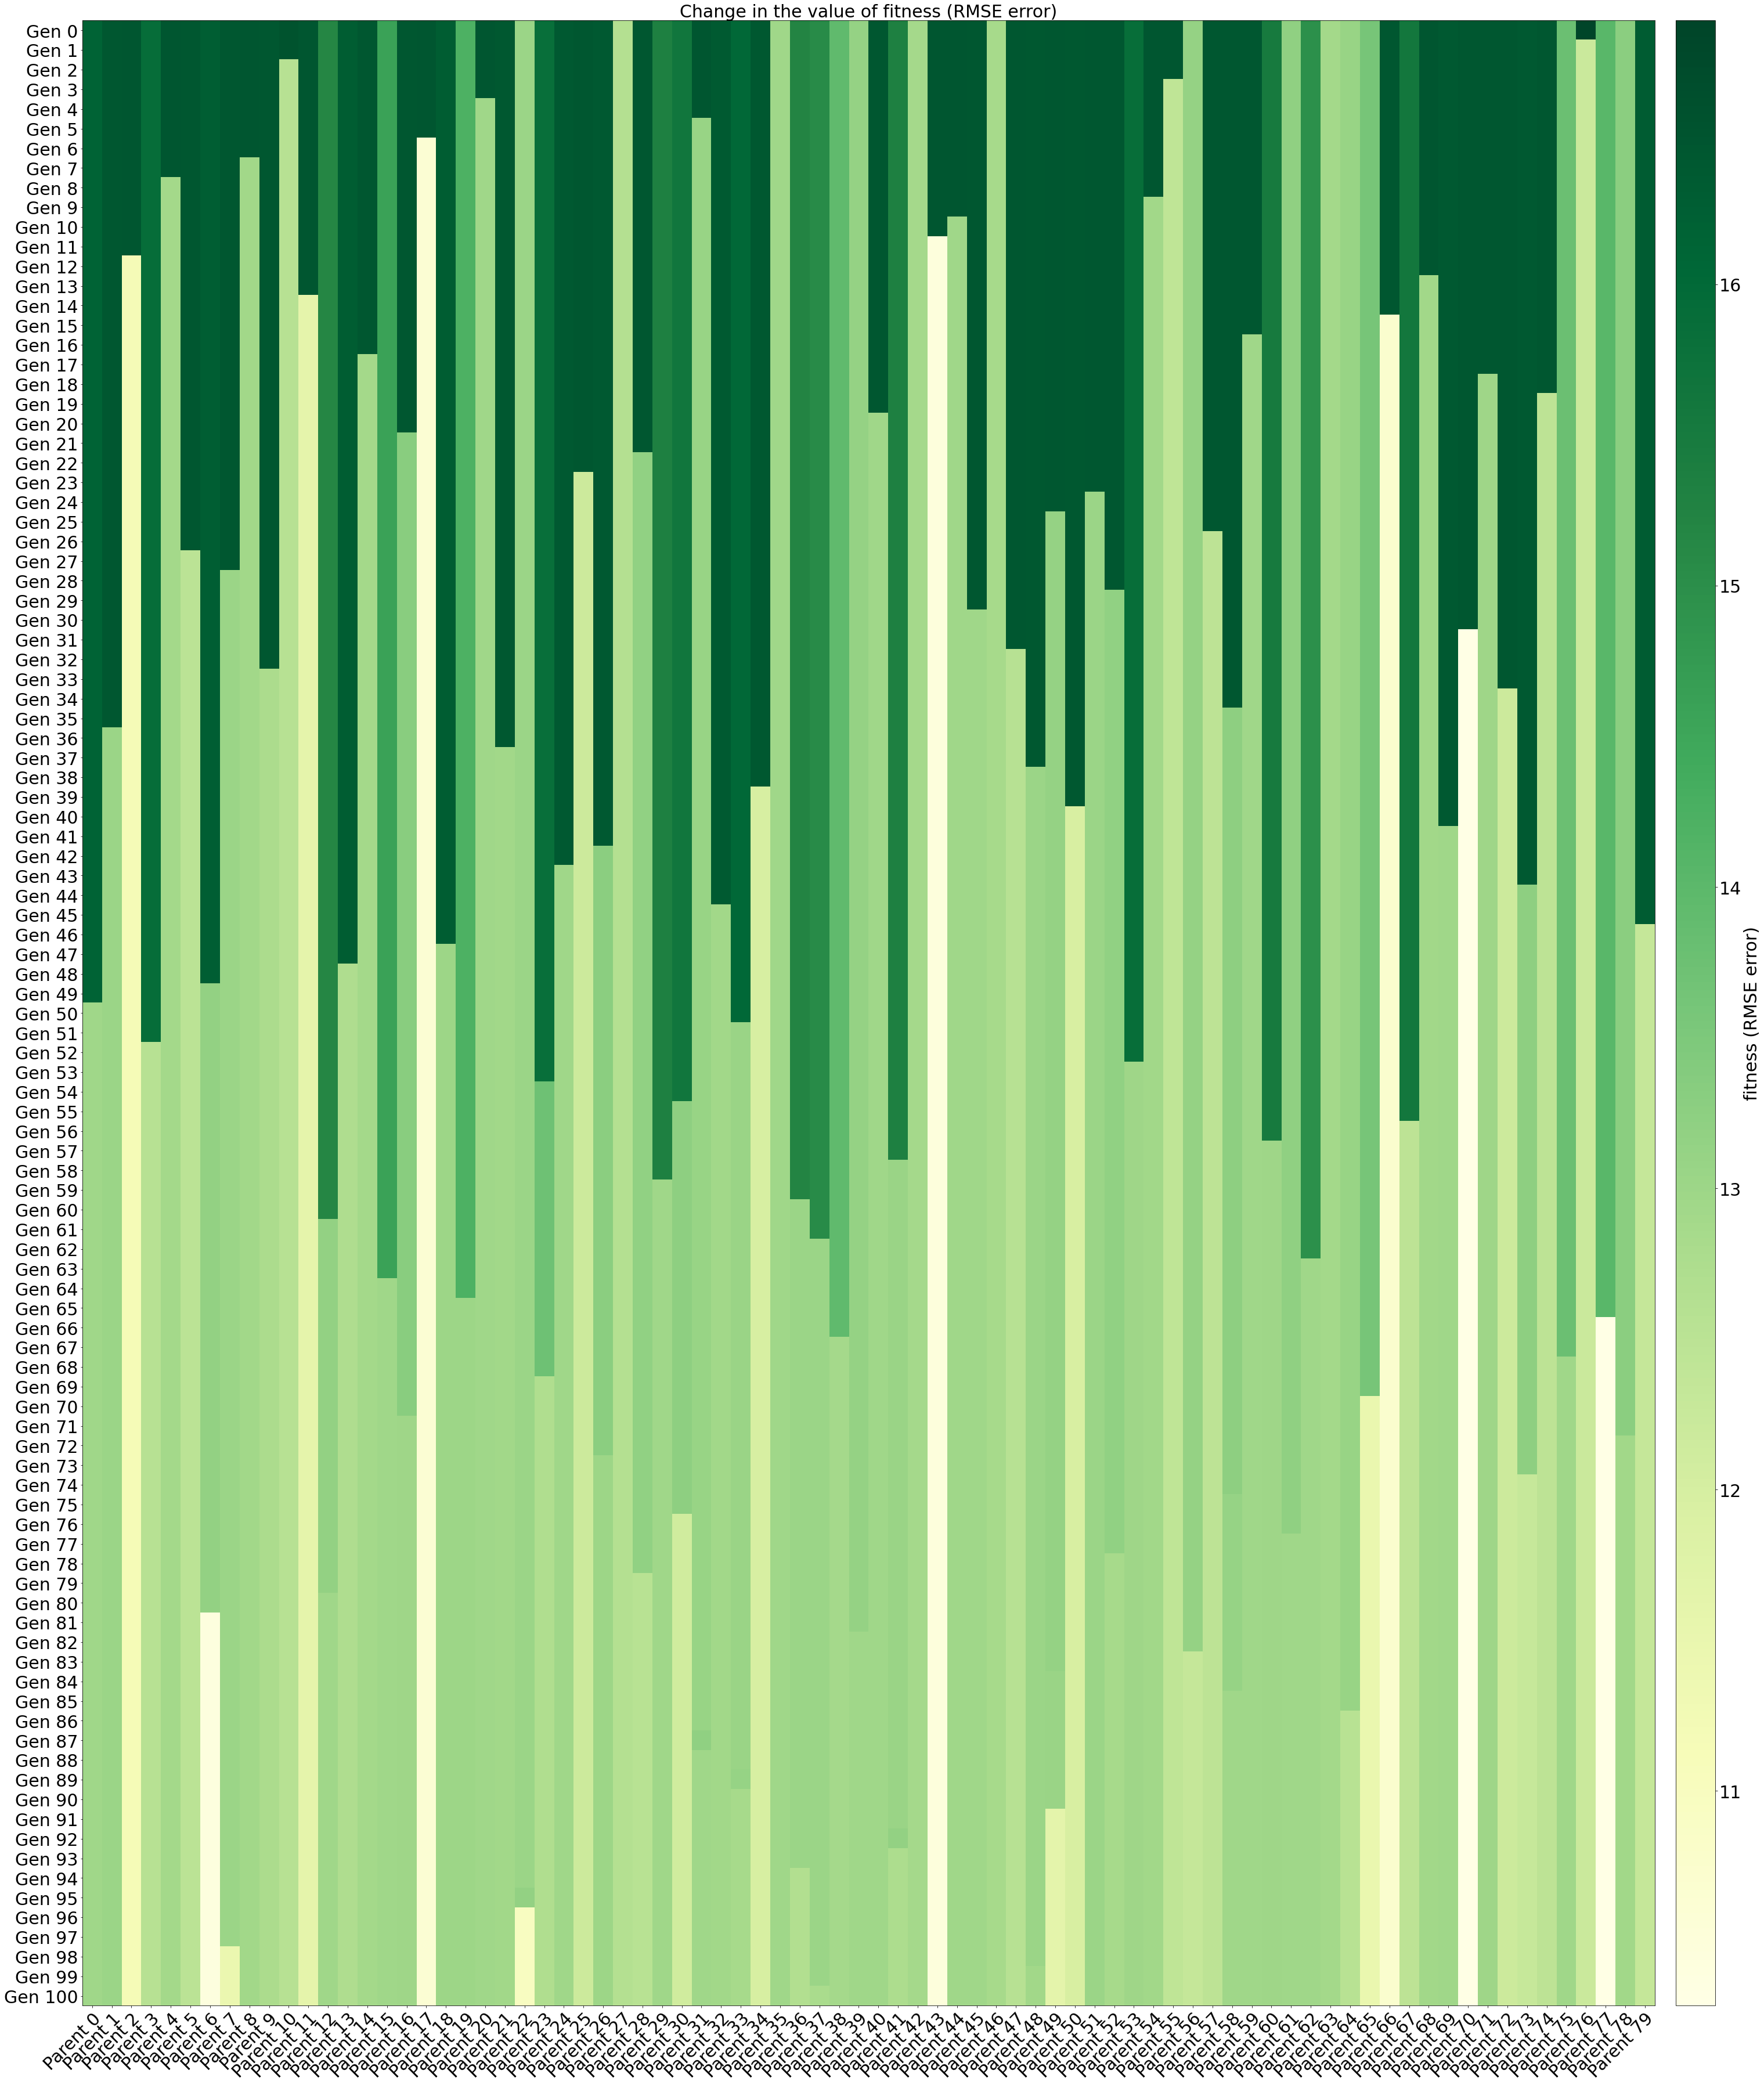

In [19]:
#visualize the change in fitness of the various generations and parents
#numberOfGenerations=20
SVM_Evolution.plot_parameters(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (RMSE error)")



In [24]:
#Look at individual parameters change with generation
#Create array for each parameter history (Genration x Parents)

C_ValueHistory = populationHistory[:, 0].reshape([numberOfGenerations+1, numberOfParents])
gamma_ValueHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])


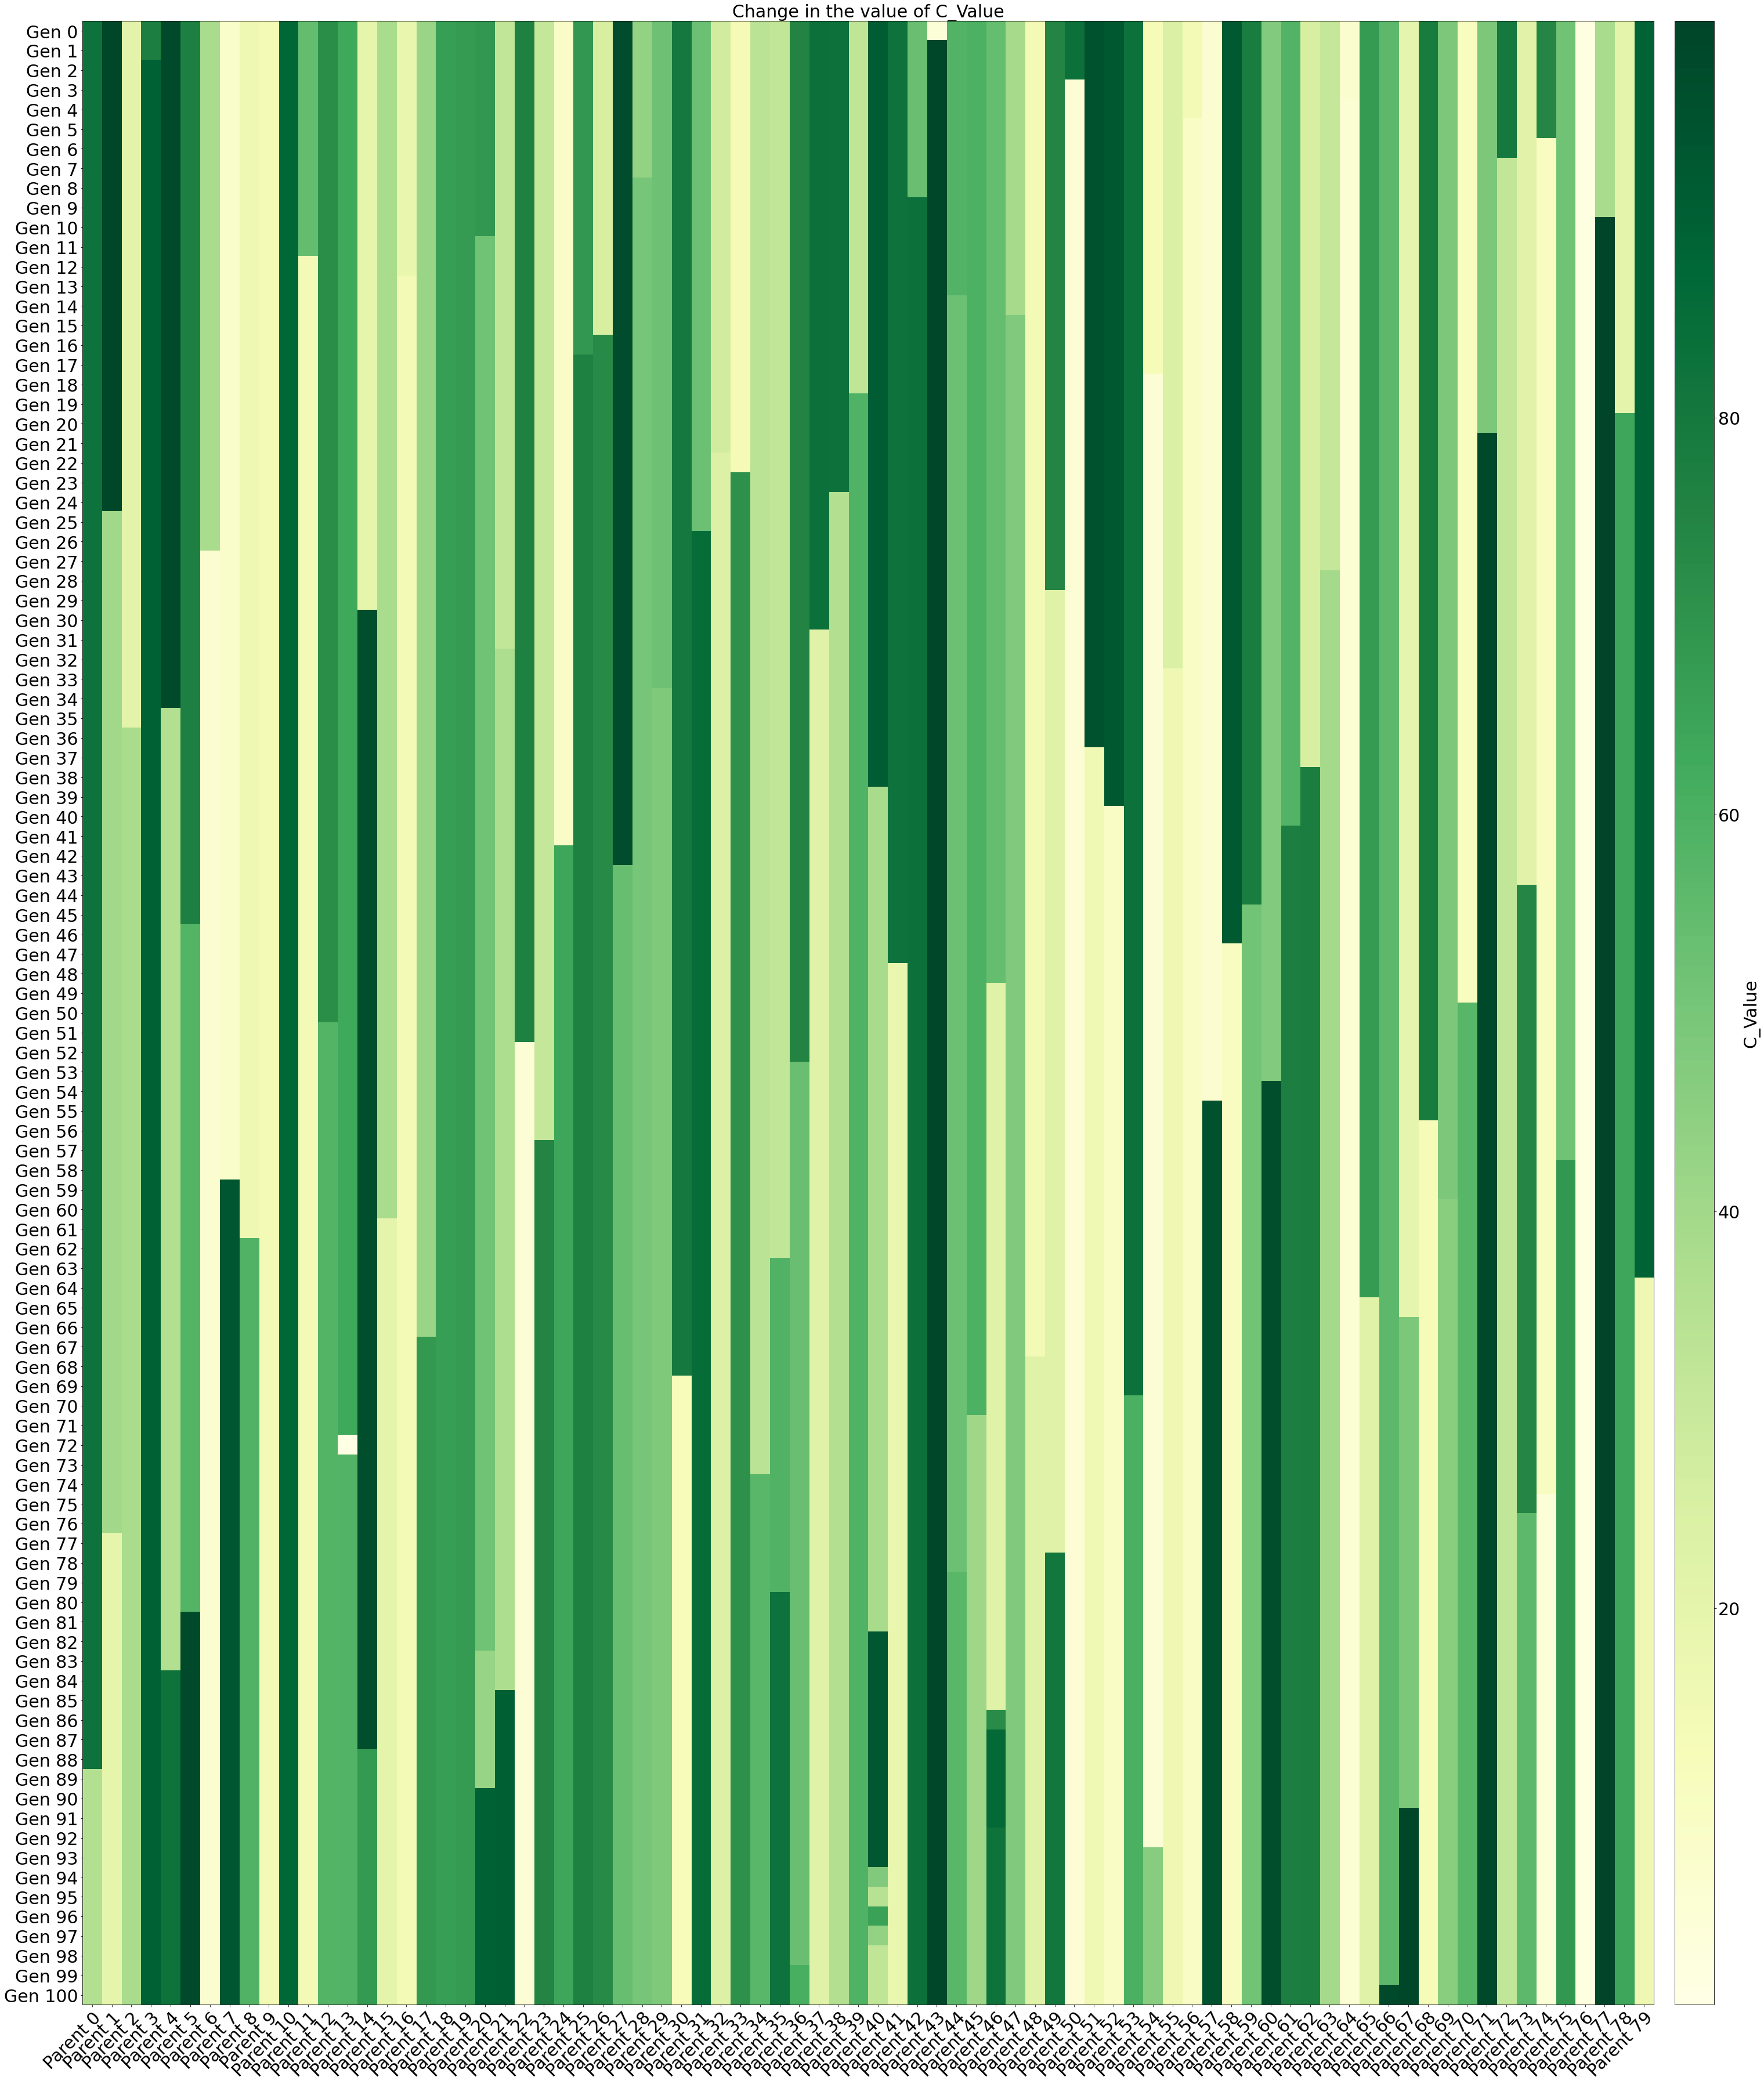

In [25]:
#generate heatmap for each parameter

SVM_Evolution.plot_parameters(numberOfGenerations, numberOfParents, C_ValueHistory, "C_Value")


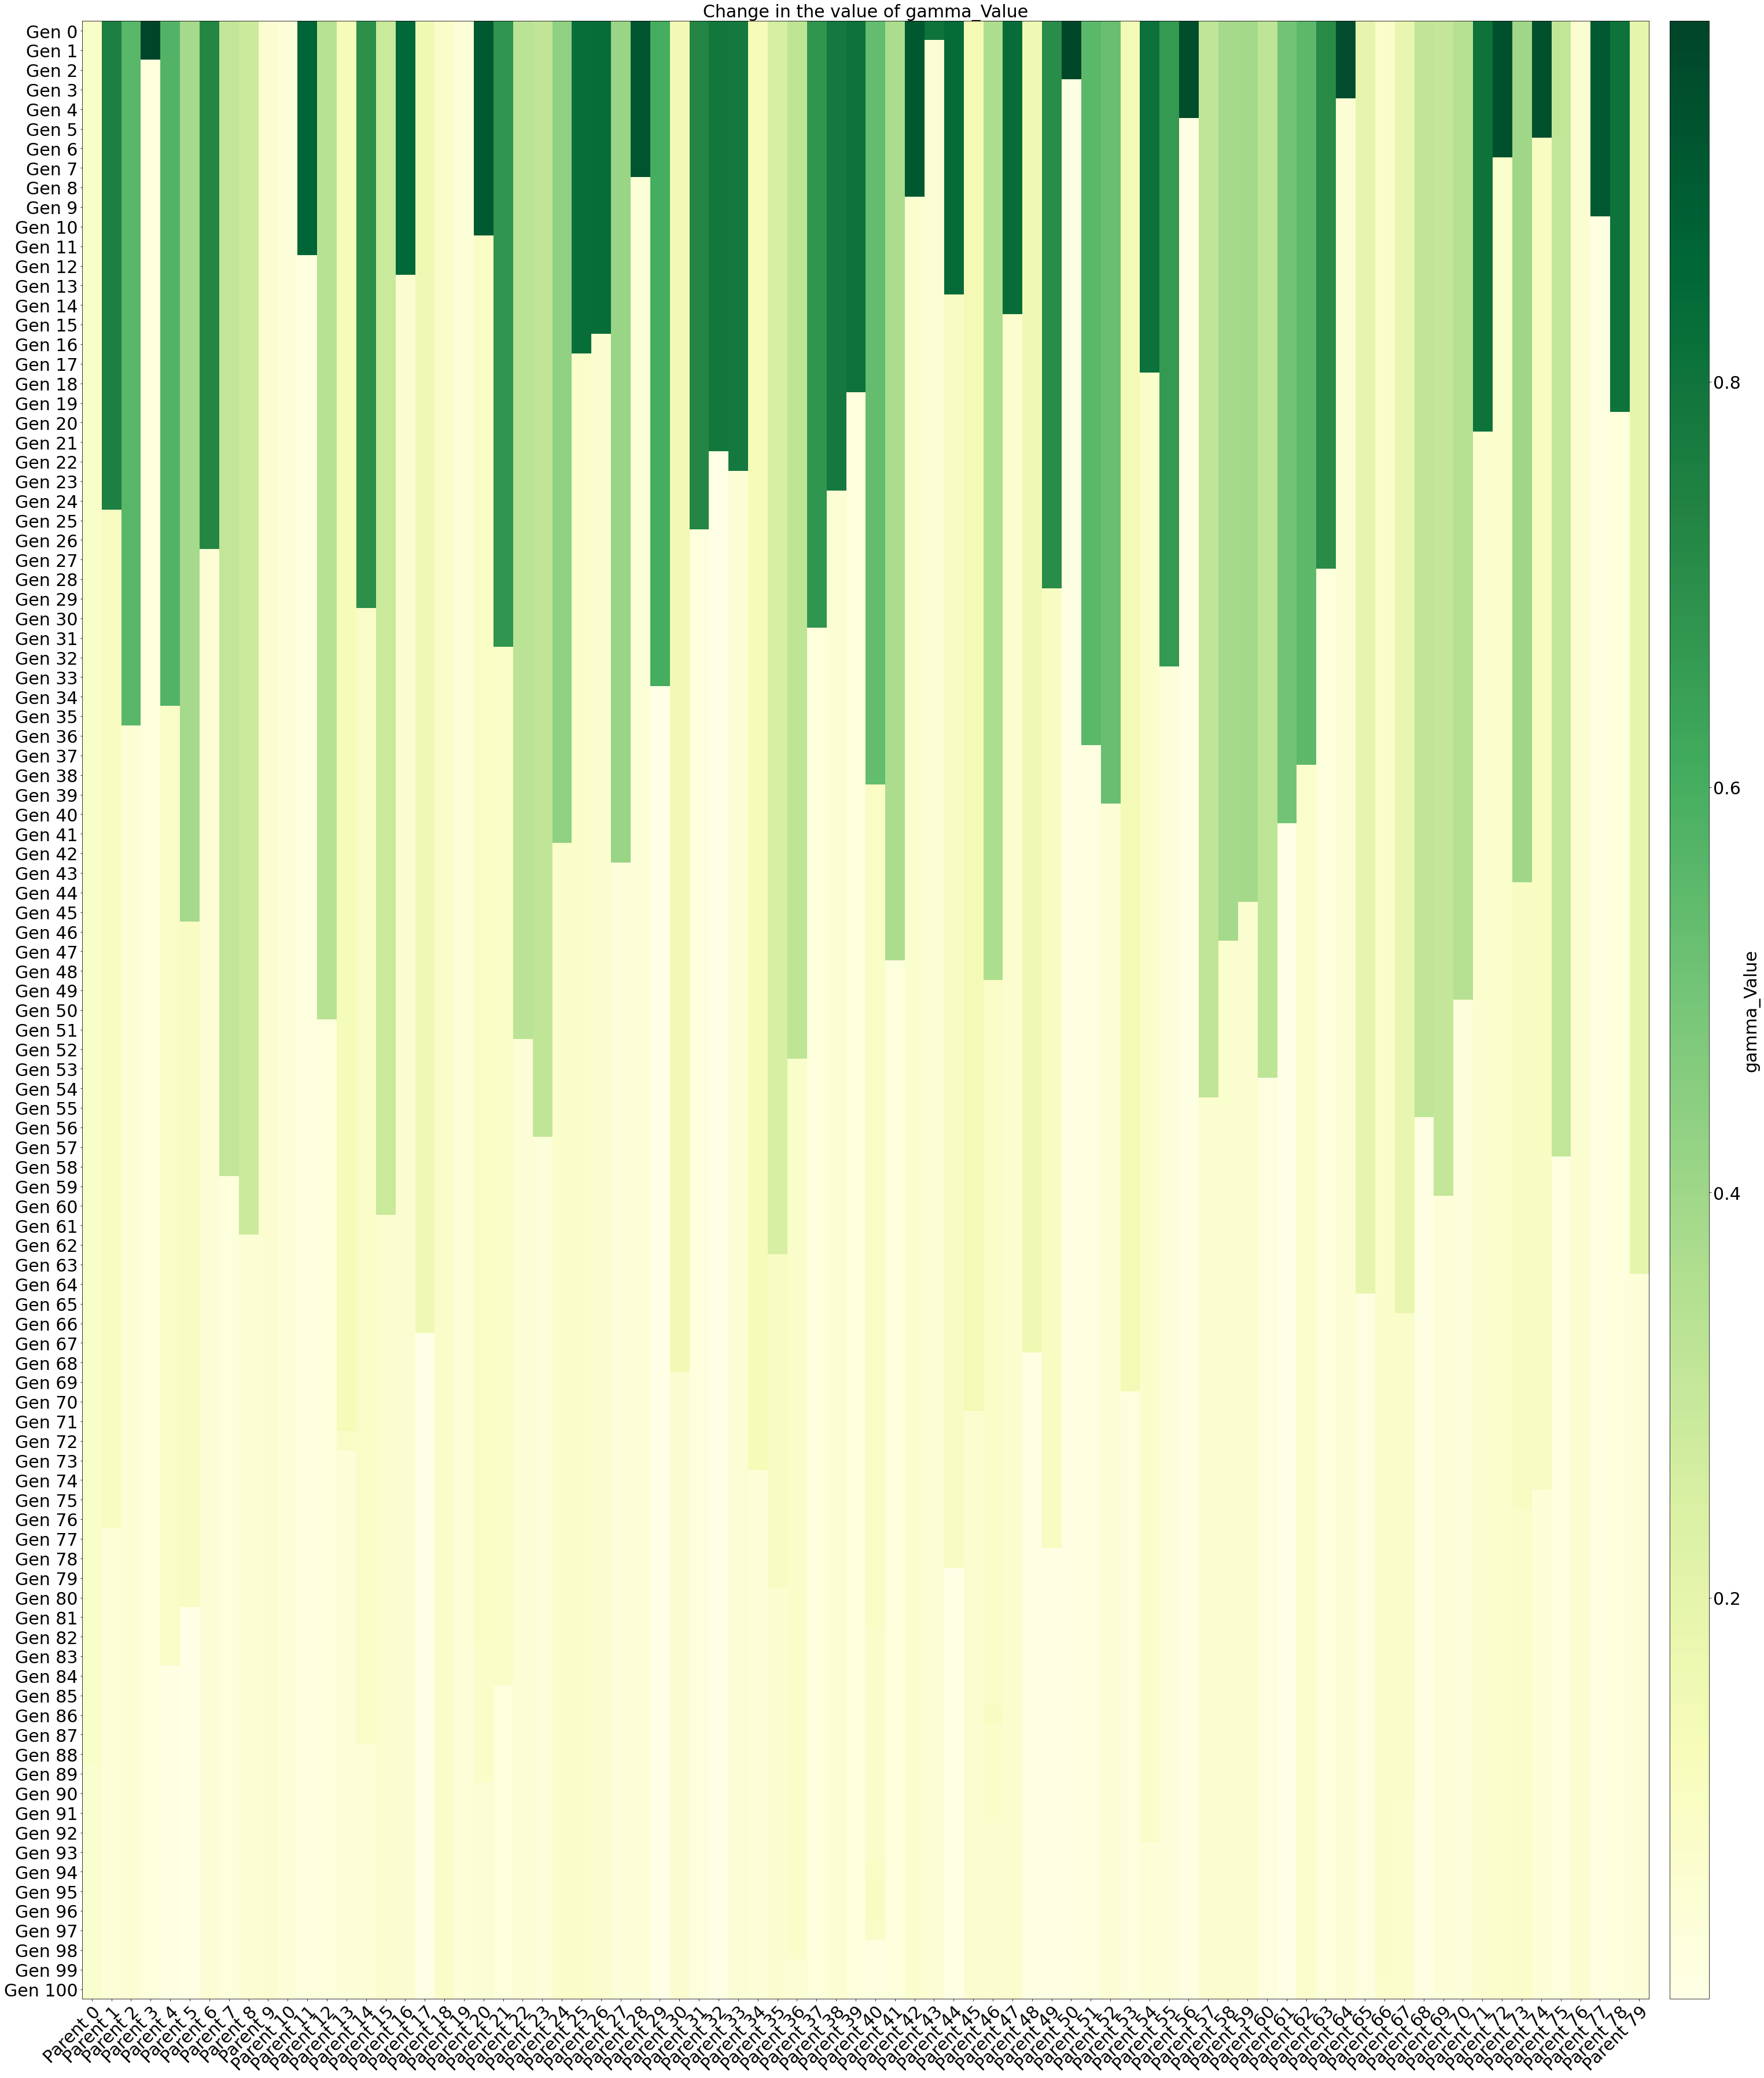

In [26]:
SVM_Evolution.plot_parameters(numberOfGenerations, numberOfParents, gamma_ValueHistory, "gamma_Value")

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [36]:
def plot_parameters2(numberOfGenerations, numberOfParents, parameter, parameterName):
    #inspired from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
    generationList = ["Gen {}".format(i) for i in range(numberOfGenerations+1)]
    populationList = ["Parent {}".format(i) for i in range(numberOfParents)]
    
    
    
    fig, ax = plt.subplots(figsize=(50,50)) #15,20 looks great formely 10,15
    im = ax.imshow(parameter, cmap=plt.get_cmap('YlGn'))
    #im = ax.imshow(parameter, cmap='hot')
    
    # show ticks
    ax.set_xticks(np.arange(len(populationList)))
    ax.set_yticks(np.arange(len(generationList)))
    
    # show labels
    ax.set_xticklabels(populationList, size='25')
    ax.set_yticklabels(generationList, size='25')
    
    # set ticks at 45 degrees and rotate around anchor
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    # insert the value of the parameter in each cell
    #for i in range(len(generationList)):
     #   for j in range(len(populationList)):
      #      text = ax.text(j, i, parameter[i, j],
       #                    ha="center", va="center", color="k", size='25')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.5)
   

    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label(parameterName, rotation=90, size='30')
    
  #  cbar=plt.colorbar(im,pad=0.04)
    
    
  #  cbar.set_label(parameterName, rotation=90)
    
    
    ax.set_title("Change in the value of " + parameterName, size='30')
    fig.tight_layout()
    plt.show()
   # plt.savefig("C:/Users/Amina Lawal/Documents/My Thesis/Original_DatasetFiles/image1.png",bbox_inches='tight',dpi=100)

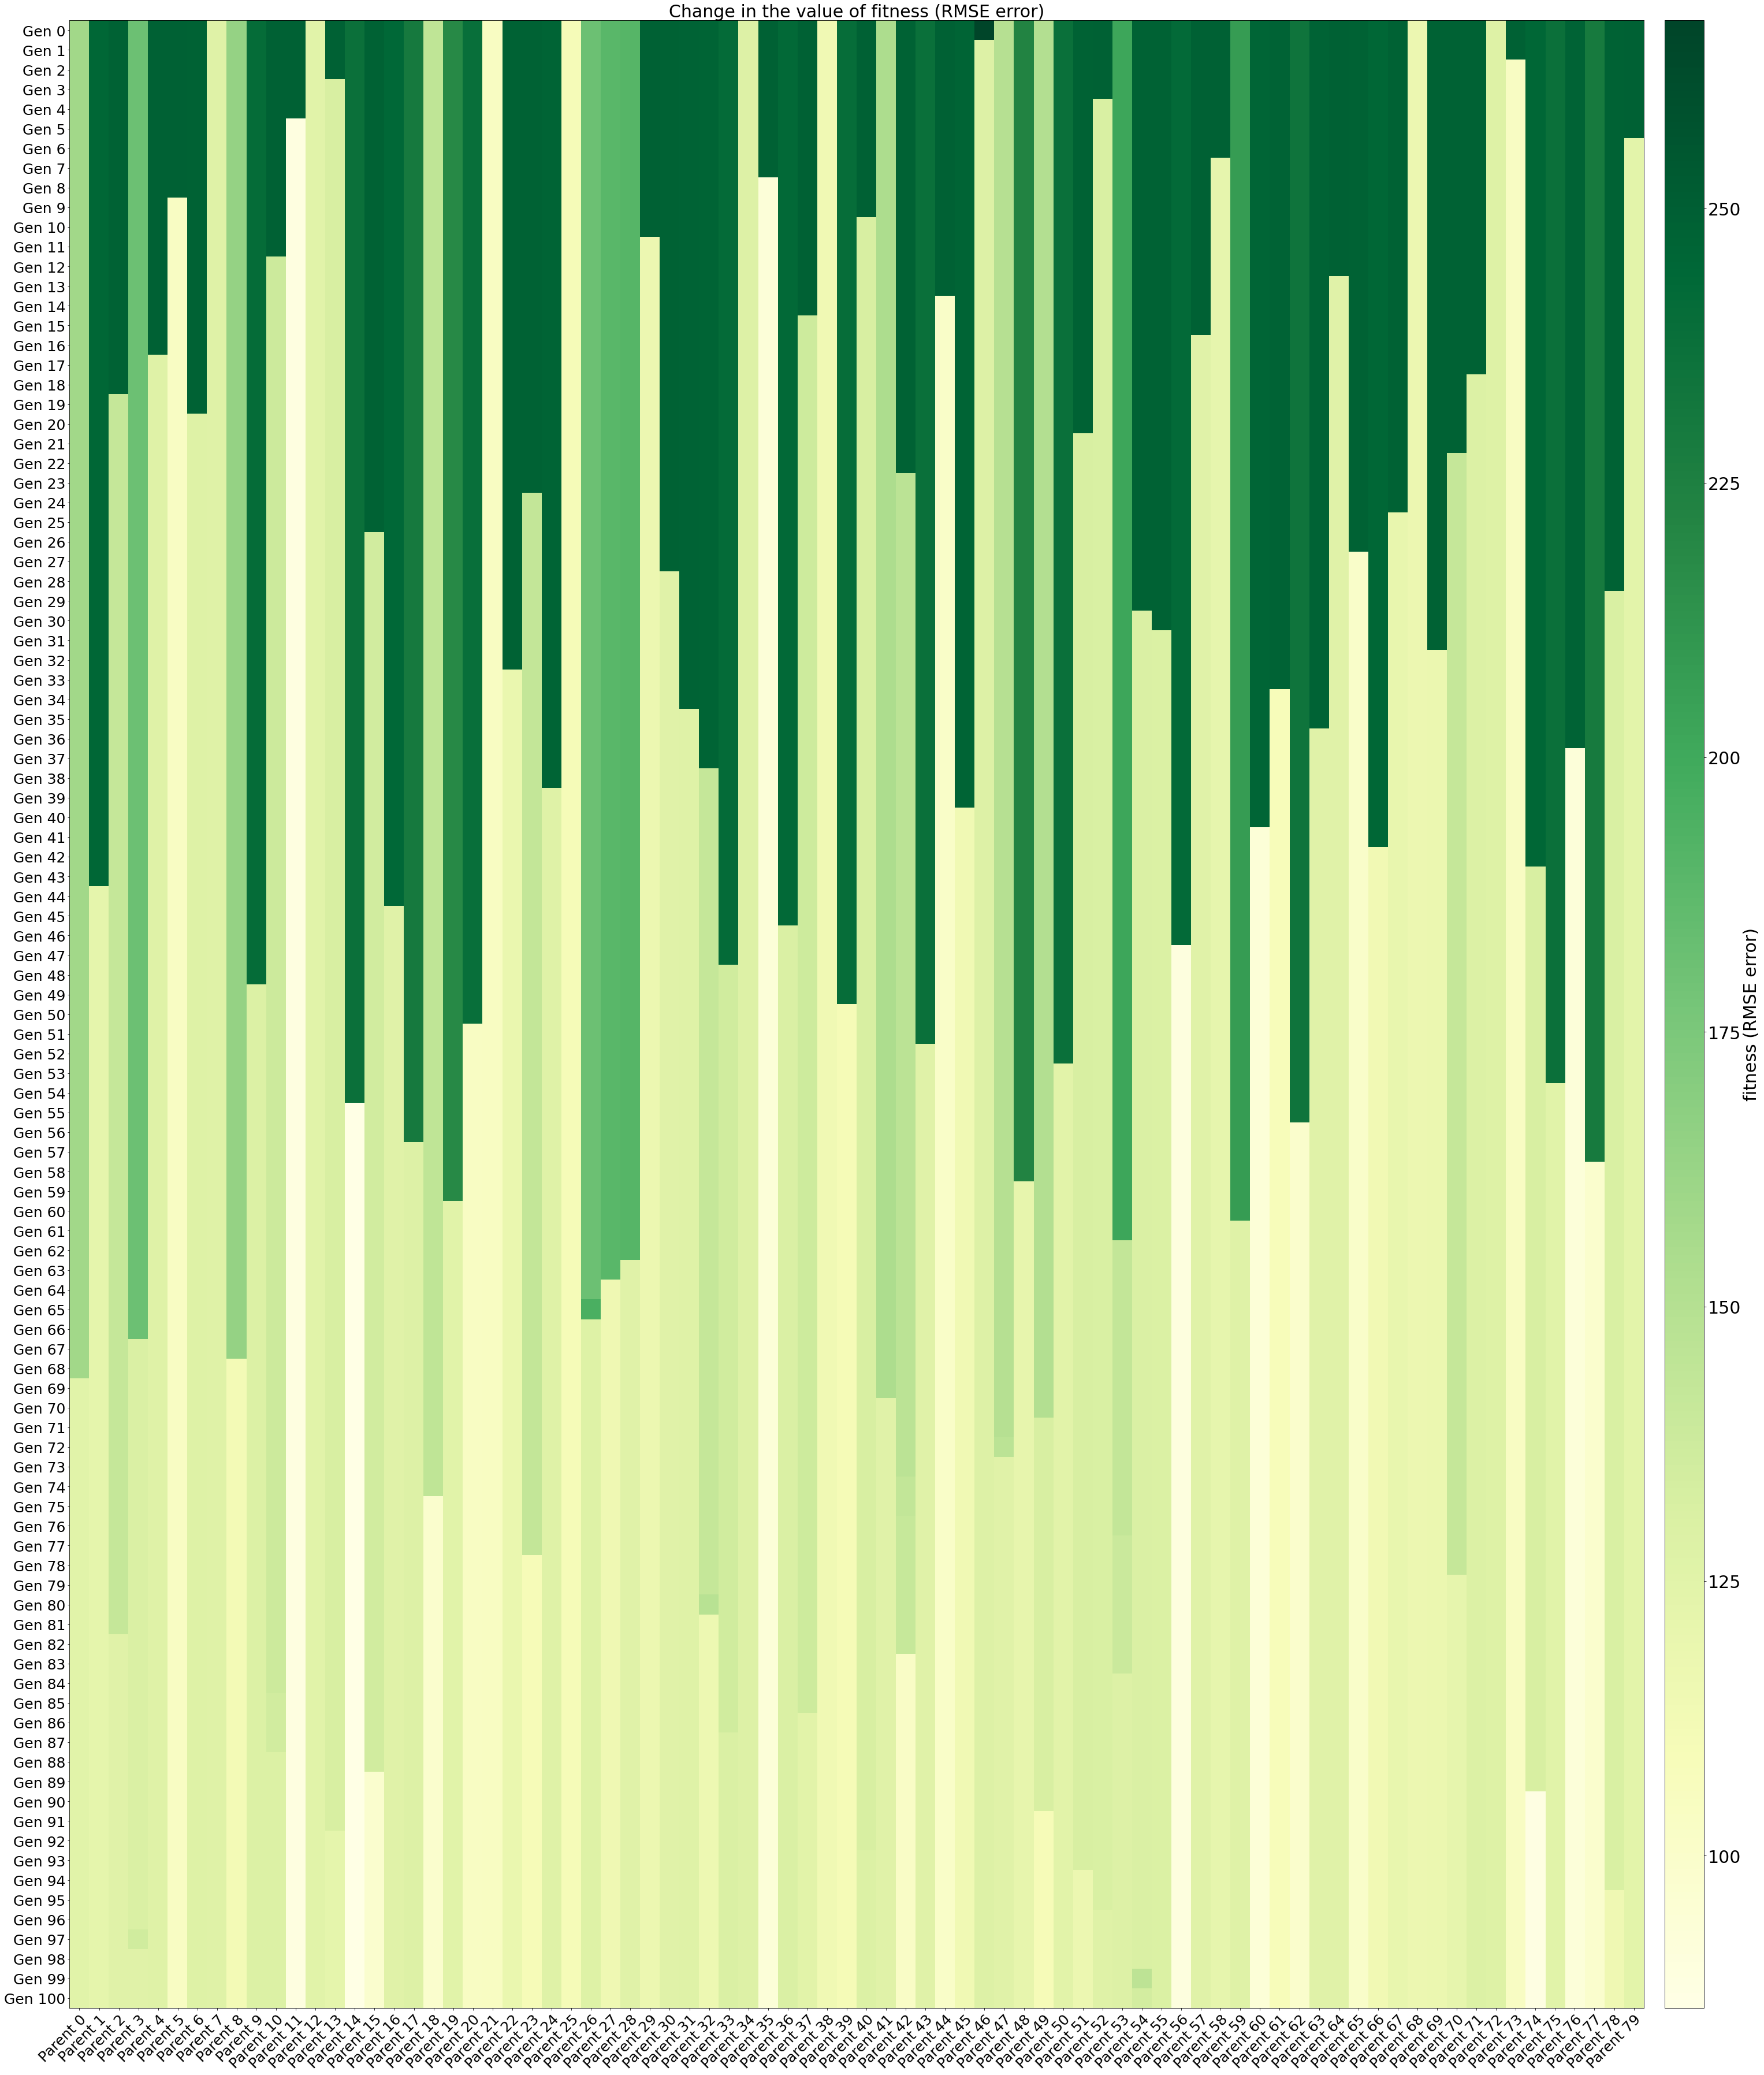

In [37]:
plot_parameters2(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (RMSE error)")

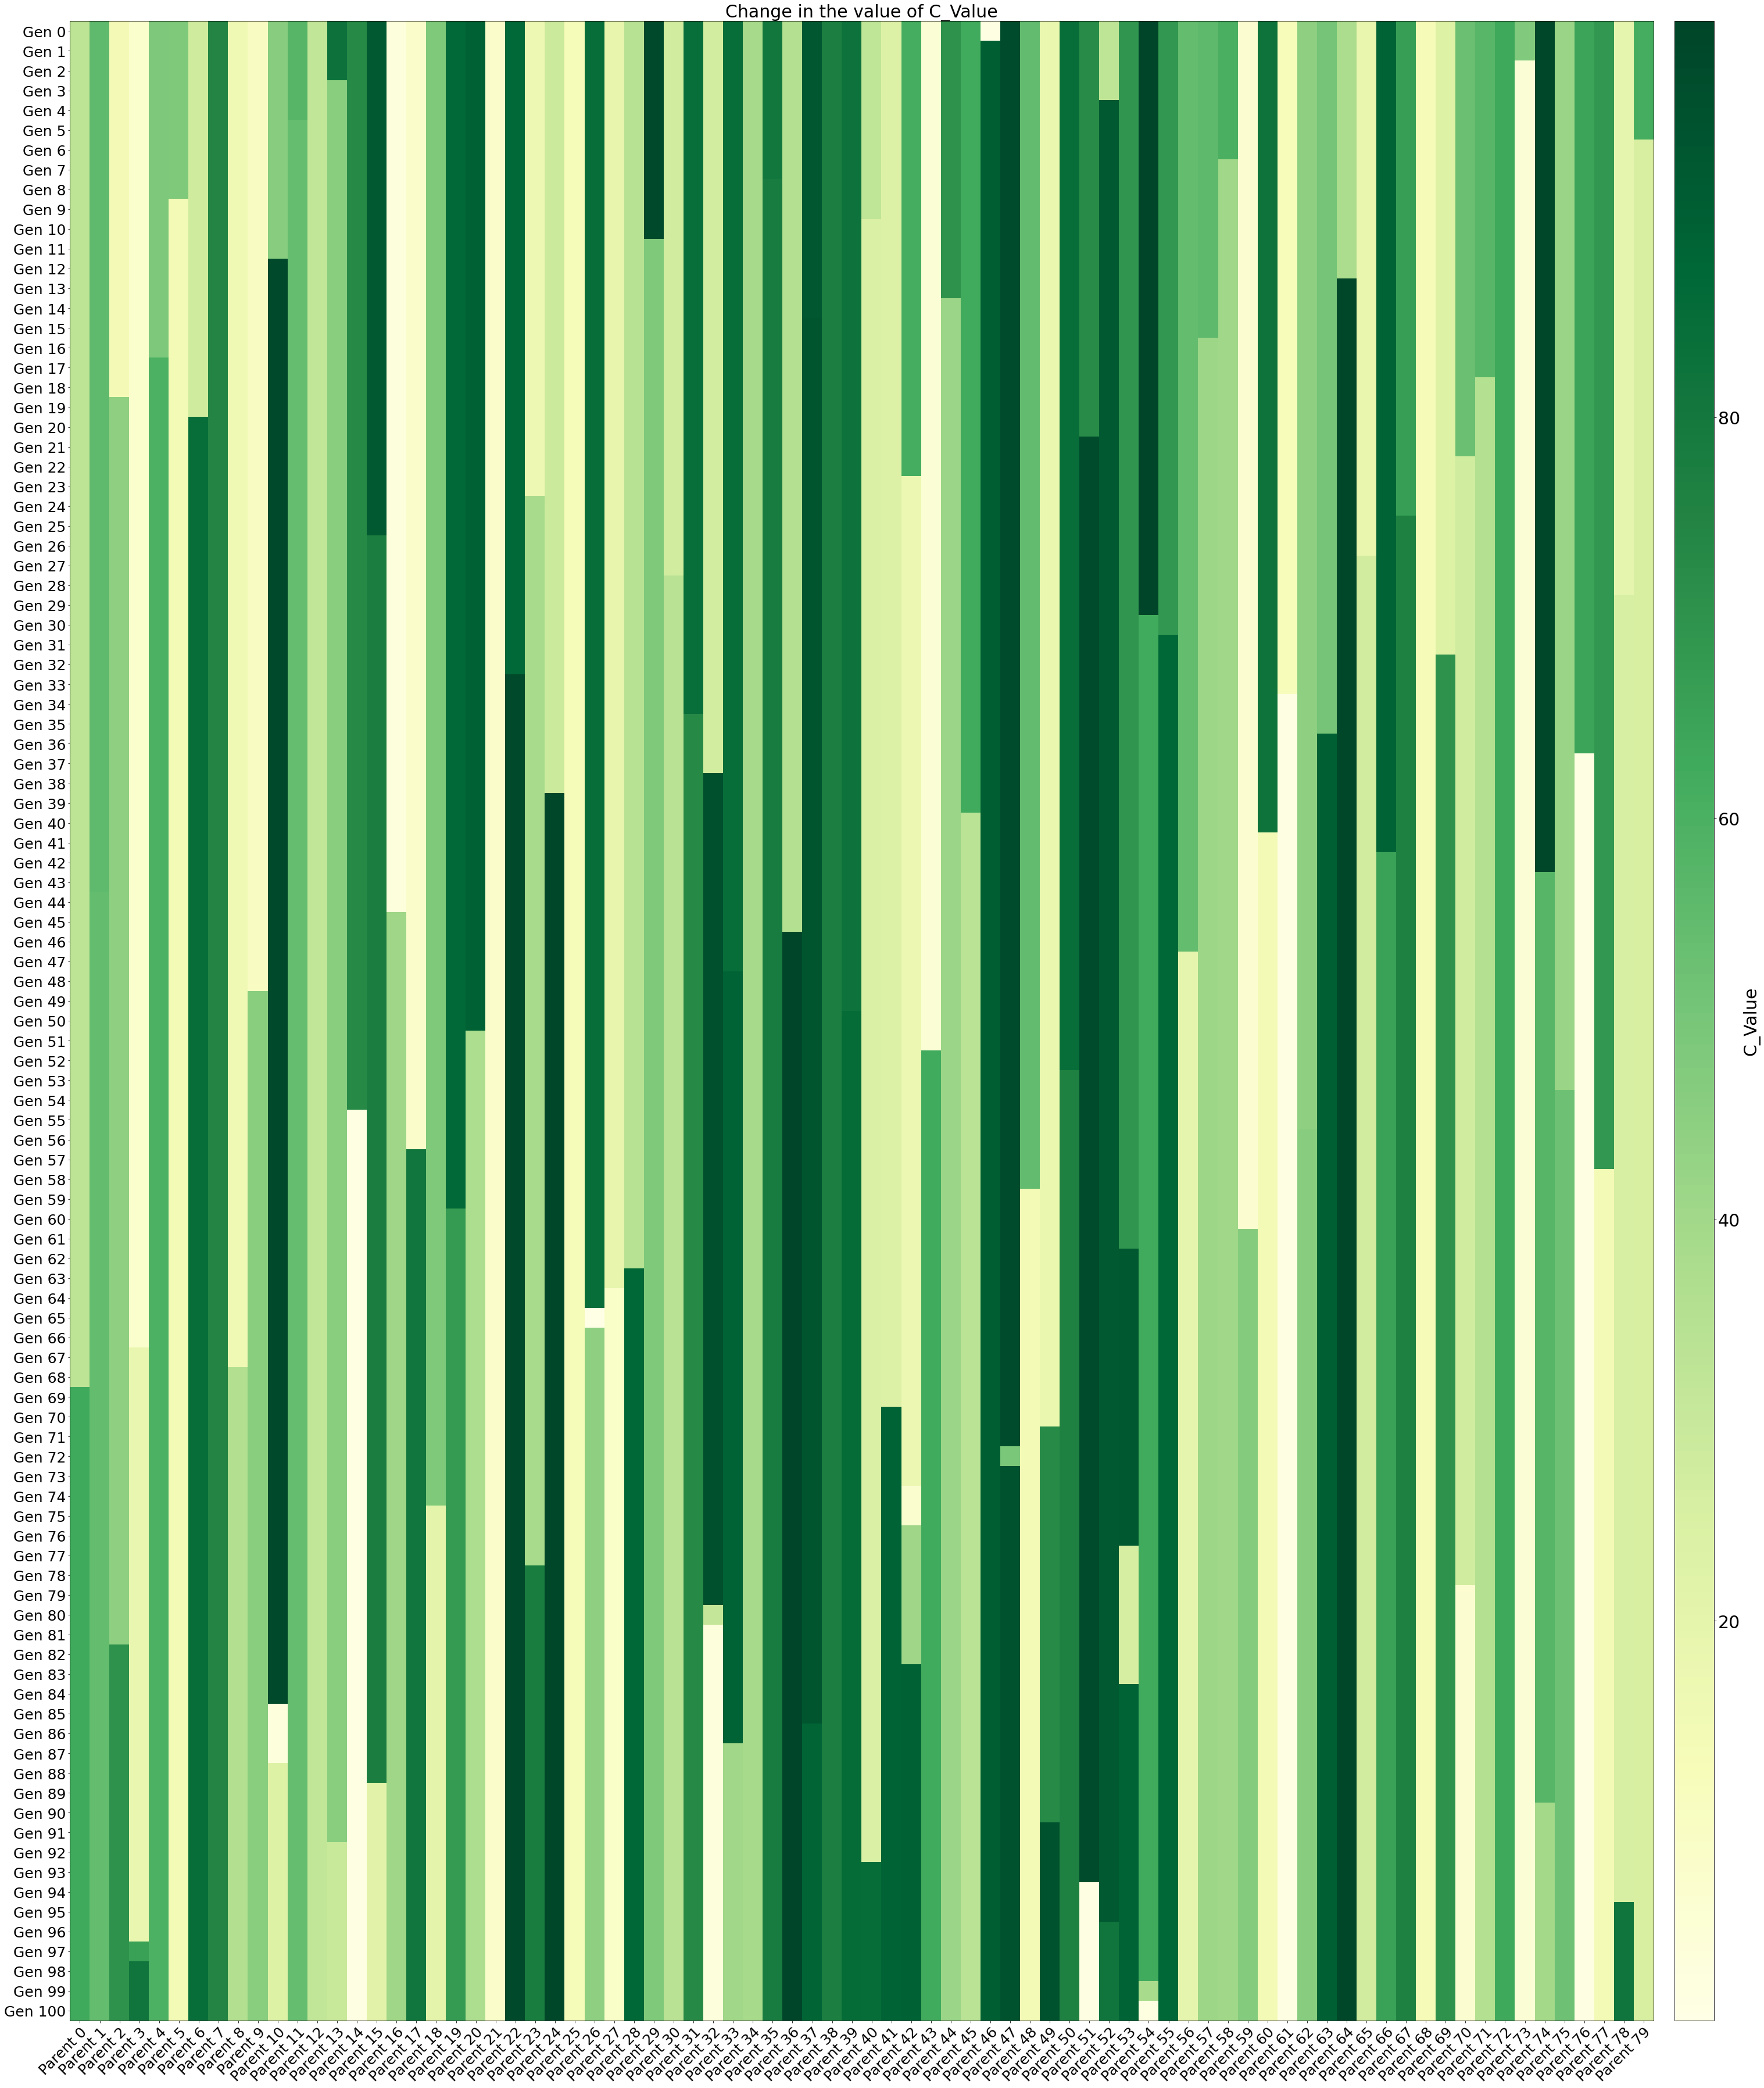

In [38]:
#generate heatmap for each parameter

plot_parameters2(numberOfGenerations, numberOfParents, C_ValueHistory, "C_Value")


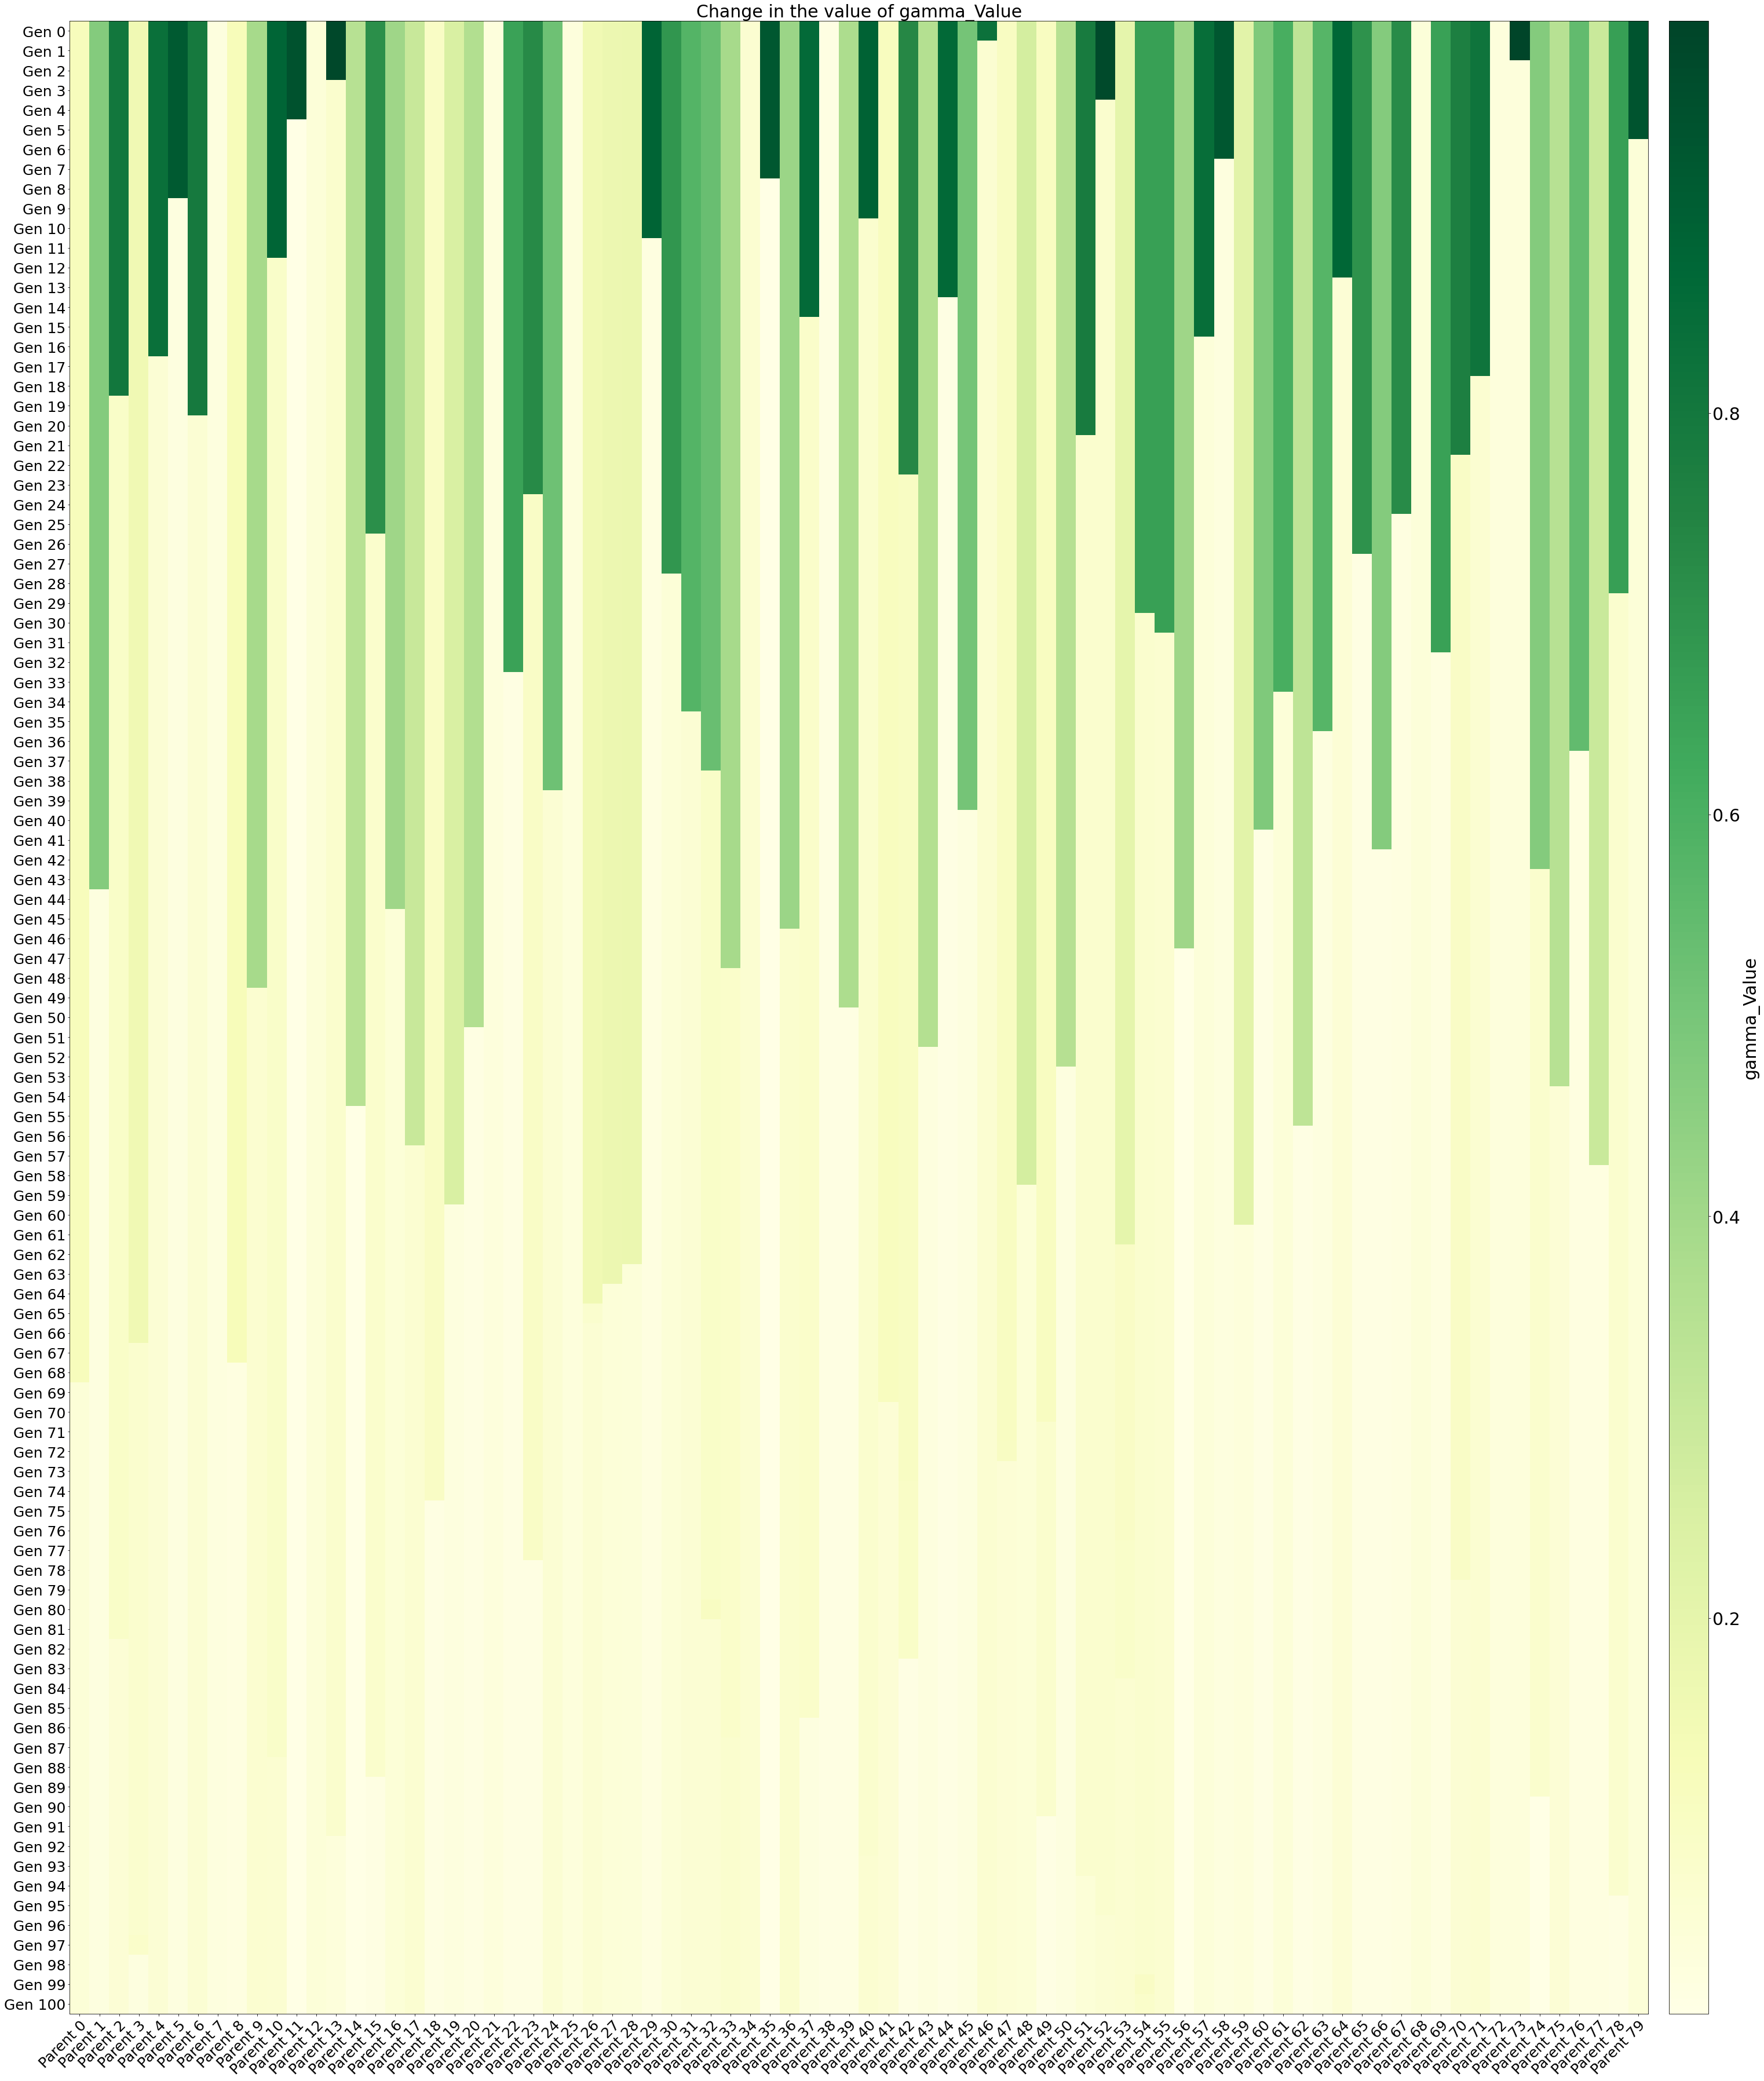

In [40]:
plot_parameters2(numberOfGenerations, numberOfParents, gamma_ValueHistory, "gamma_Value")

In [41]:
def plot_parameters3(numberOfGenerations, numberOfParents, parameter, parameterName):
    #inspired from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
    generationList = ["Gen {}".format(i) for i in range(numberOfGenerations+1)]
    populationList = ["Parent {}".format(i) for i in range(numberOfParents)]
    
    genList= generationList[-20:]
    popList= populationList[-20:]
    
    parameter=parameter[-20:]
    
    fig, ax = plt.subplots(figsize=(15,20)) #15,20
    
    im = ax.imshow(parameter, cmap=plt.cm.Blues)
    #im = ax.imshow(parameter, cmap=plt.get_cmap('YlGn'))
    
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(popList)))
    ax.set_yticks(np.arange(len(genList)))
    
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(popList)
    ax.set_yticklabels(genList)
    
    ax.set_xlim(0,20)
    #ax.set_ylim(0,20)
    
    ax.tick_params(direction='out', length=10, width=0, colors='k',
               grid_color='k', grid_alpha=0.5)
    

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(popList)):
        for j in range(len(genList)):
            
            #round to integer if box is to tight
            text = ax.text(j, i, int(round(parameter[i, j])),
                           ha="left", va="bottom", color="k")
            #text = ax.text(j, i, parameter[i, j],
             #              ha="left", va="center", color="k")
            
    #heatmap= plt.pcolor(parameter, )
    #plt.colorbar(heatmap)
    cbar=plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.set_label(parameterName, rotation=90)

    ax.set_title("Change in the value of " + parameterName)

    
    fig.tight_layout()
    plt.show()

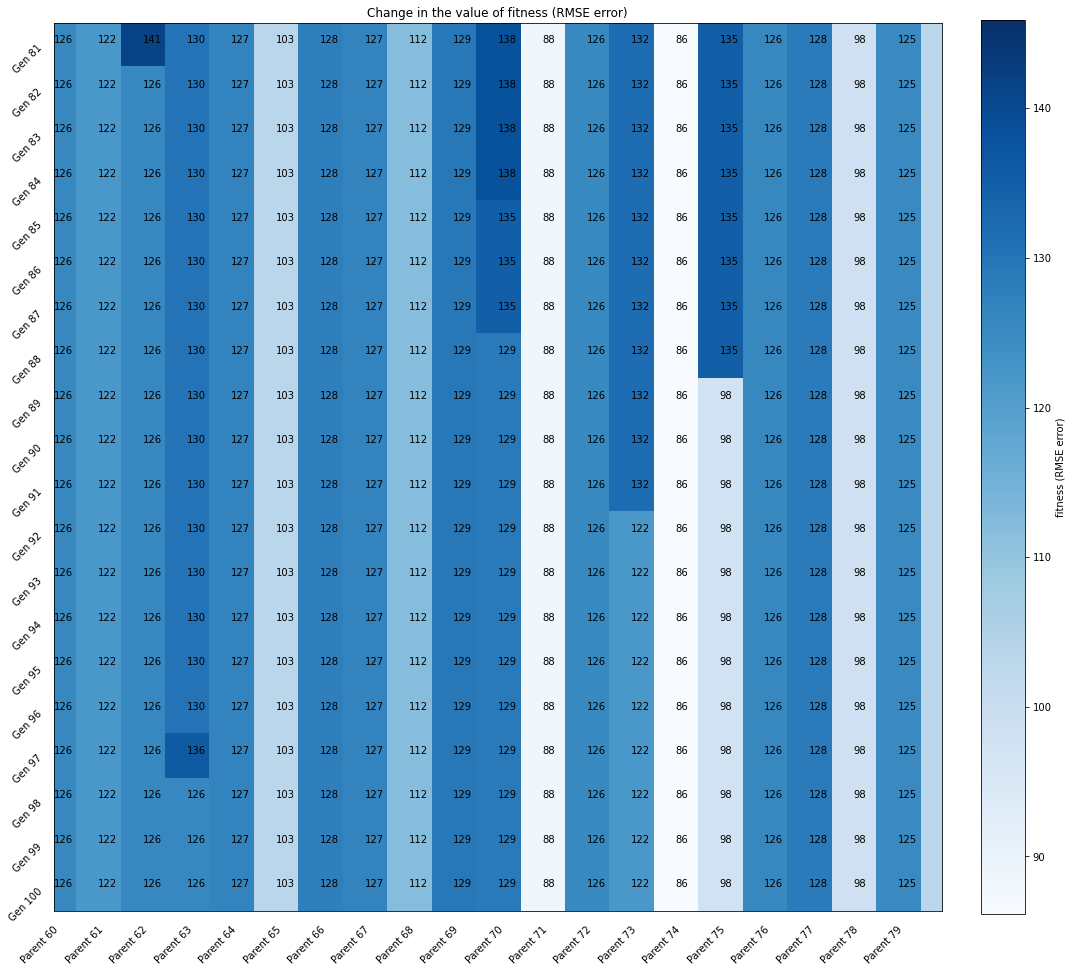

In [42]:
plot_parameters3(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (RMSE error)")